In [1]:
pip install transformers datasets


Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install rouge-score

Note: you may need to restart the kernel to use updated packages.


In [3]:
!pip install rouge

In [4]:
import random
import numpy as np
from transformers import pipeline
import pandas as pd

from rouge import Rouge

# Initialize the ROUGE scorer
#rouge = Rouge()

In [5]:
pip install datasets


Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: urllib3<1.27,>=1.21.1 in c:\users\athir\anaconda3\lib\site-packages (from requests>=2.19.0->datasets) (1.26.9)



In [6]:
from datasets import load_dataset

# Load the CNN/Daily Mail dataset
dataset = load_dataset('cnn_dailymail', '3.0.0')

In [7]:
# Analyze the dataset
print(dataset['train'].shape)  # Display the number of training samples
print(dataset['train'][0])  # Display the first training sample

(287113, 3)
{'article': 'LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won\'t cast a spell on him. Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the Phoenix" To the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parties. "I don\'t plan to be one of those people who, as soon as they turn 18, suddenly buy themselves a massive sports car collection or something similar," he told an Australian interviewer earlier this month. "I don\'t think I\'ll be particularly extravagant. "The things I like buying are things that cost about 10 pounds -- books and CDs and DVDs." At 18, Radcliffe will be able to gamble in a casino, buy a drink in a pub or see the horror film "Hostel: Part II," currently six places below his number one movie on the UK box

In [8]:
# Extract articles and summaries
articles = [item['article'] for item in dataset['train']]
reference_summaries = [item['highlights'] for item in dataset['train']]

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

def lead_based_summarization(article, num_sentences=3):
    """Return the first few sentences of the article."""
    return ' '.join(article.split('.')[:num_sentences]) + '.'

def keyword_based_summarization(article, num_sentences=3):
    """Return sentences containing the most frequent keywords."""
    words = [word for word in article.split() if word.isalnum()]
    most_common_words = set(sorted(words, key=words.count, reverse=True)[:10])
    sentences = article.split('.')
    top_sentences = [sentence for sentence in sentences if any(word in sentence for word in most_common_words)]
    return '. '.join(top_sentences[:num_sentences]) + '.'

def sentence_length_summarization(article, num_sentences=3):
    """Return the longest sentences."""
    sentences = article.split('.')
    sorted_sentences = sorted(sentences, key=len, reverse=True)
    return '. '.join(sorted_sentences[:num_sentences]) + '.'

def positional_summarization(article, num_sentences=3):
    """Return sentences from the beginning, middle, and end."""
    sentences = article.split('.')
    total_sentences = len(sentences)
    start = sentences[0]
    middle = sentences[total_sentences // 2]
    end = sentences[-1]
    return '. '.join([start, middle, end]) + '.'

def tfidf_summarization(article, num_sentences=3):
    """Return sentences with the highest average TF-IDF scores."""
    vectorizer = TfidfVectorizer()
    sentences = article.split('.')
    tfidf_matrix = vectorizer.fit_transform(sentences)
    avg_tfidf_scores = np.mean(tfidf_matrix.toarray(), axis=1)
    ranked_sentences = [sentences[i] for i in np.argsort(avg_tfidf_scores, axis=0)[-num_sentences:]]
    return '. '.join(ranked_sentences) + '.'


In [10]:
!pip install rouge


In [11]:
print(len(articles))
print(len(reference_summaries))


287113
287113


In [12]:
from rouge import Rouge

# Placeholder for results
results = {}

# List of techniques
techniques = [
    lead_based_summarization, 
    keyword_based_summarization,
    sentence_length_summarization,
    positional_summarization,
    tfidf_summarization
]

# Initialize Rouge evaluator
rouge = Rouge()

# Evaluate each technique on the first 100 articles for faster execution
for technique in techniques:
    generated_summaries = [technique(article) for article in articles[:100]]
    scores = rouge.get_scores(generated_summaries, reference_summaries[:100], avg=True)
    
    # Store the results
    results[technique.__name__] = {
        'rouge-1': scores['rouge-1']['f'],
        'rouge-2': scores['rouge-2']['f'],
        'rouge-l': scores['rouge-l']['f']
    }

# Print the results
for technique, score in results.items():
    print(f"Technique: {technique}")
    print(f"ROUGE-1: {score['rouge-1']:.4f}")
    print(f"ROUGE-2: {score['rouge-2']:.4f}")
    print(f"ROUGE-L: {score['rouge-l']:.4f}")
    print('-' * 50)


Technique: lead_based_summarization
ROUGE-1: 0.2841
ROUGE-2: 0.1041
ROUGE-L: 0.2413
--------------------------------------------------
Technique: keyword_based_summarization
ROUGE-1: 0.2725
ROUGE-2: 0.0903
ROUGE-L: 0.2477
--------------------------------------------------
Technique: sentence_length_summarization
ROUGE-1: 0.2157
ROUGE-2: 0.0586
ROUGE-L: 0.1975
--------------------------------------------------
Technique: positional_summarization
ROUGE-1: 0.2250
ROUGE-2: 0.0682
ROUGE-L: 0.2021
--------------------------------------------------
Technique: tfidf_summarization
ROUGE-1: 0.2025
ROUGE-2: 0.0517
ROUGE-L: 0.1847
--------------------------------------------------


In [13]:
def voting_based_ensemble(base_summaries):
    # Count the occurrence of each sentence
    sentence_counts = {}
    for summary in base_summaries:
        for sentence in summary.split('.'):
            sentence_counts[sentence] = sentence_counts.get(sentence, 0) + 1
    
    # Rank sentences based on their count
    ranked_sentences = sorted(sentence_counts.items(), key=lambda x: x[1], reverse=True)
    
    # Extract top N sentences
    N = 3
    top_sentences = [ranked_sentences[i][0] for i in range(N)]
    return ' '.join(top_sentences)

def ranked_list_ensemble(base_summaries):
    # Rank each sentence based on its position
    sentence_ranks = {} 
    for summary in base_summaries:
        for idx, sentence in enumerate(summary.split('.')):
            if sentence in sentence_ranks:
                sentence_ranks[sentence].append(idx)
            else:
                sentence_ranks[sentence] = [idx]
    
    # Compute average rank for each sentence
    avg_ranks = {sentence: sum(ranks)/len(ranks) for sentence, ranks in sentence_ranks.items()}
    
    # Rank sentences based on their average rank
    ranked_sentences = sorted(avg_ranks.items(), key=lambda x: x[1])
    
    # Extract top N sentences
    N = 3
    top_sentences = [ranked_sentences[i][0] for i in range(N)]
    return ' '.join(top_sentences)


In [14]:
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

def simple_graph_based_ensemble(base_summaries):
    # Combine all base summaries into a single text
    combined_summary = ' '.join(base_summaries)
    
    # Split the combined summary into sentences
    sentences = combined_summary.split('.')
    
    # Compute TF-IDF vectors for each sentence
    vectorizer = TfidfVectorizer().fit_transform(sentences)
    vectors = vectorizer.toarray()
    
    # Compute cosine similarity between sentences
    cosine_matrix = cosine_similarity(vectors)
    
    # Create a graph and use cosine similarity as weights for edges
    graph = nx.Graph()
    for i in range(len(sentences)):
        for j in range(len(sentences)):
            if i != j:
                graph.add_edge(i, j, weight=cosine_matrix[i][j])
                
    # Rank sentences based on their degree
    scores = nx.degree(graph, weight='weight')
    ranked_sentences = sorted(((scores[i], s) for i, s in enumerate(sentences)), reverse=True)
    
    # Extract top N sentences as the ensemble summary
    N = 3
    top_sentences = [ranked_sentences[i][1] for i in range(N)]
    return ' '.join(top_sentences)


In [15]:
pip install --upgrade networkx scipy


Note: you may need to restart the kernel to use updated packages.


In [16]:
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

def centrality_based_ensemble(base_summaries):
    # Combine all base summaries into a single text
    combined_summary = ' '.join(base_summaries)
    
    # Split the combined summary into sentences
    sentences = combined_summary.split('.')
    
    # Compute TF-IDF vectors for each sentence
    vectorizer = TfidfVectorizer().fit_transform(sentences)
    vectors = vectorizer.toarray()
    
    # Compute cosine similarity between sentences
    cosine_matrix = cosine_similarity(vectors)
    
    # Create a graph and use cosine similarity as weights for edges
    graph = nx.from_numpy_array(cosine_matrix)
    
    # Rank sentences based on their eigenvector centrality
    centrality_scores = nx.eigenvector_centrality(graph, max_iter=1000, tol=1e-06)
    ranked_sentences = sorted(((centrality_scores[i], s) for i, s in enumerate(sentences)), reverse=True)
    
    # Extract top N sentences as the ensemble summary
    N = 3
    top_sentences = [ranked_sentences[i][1] for i in range(N)]
    return ' '.join(top_sentences)



In [17]:
# Generate base summaries for each article:

base_summaries_list = []

for article in articles[:100]:  # Using the first 100 articles for faster execution
    base_summaries = {
        'lead_based': lead_based_summarization(article),
        'keyword_based': keyword_based_summarization(article),
        'sentence_length': sentence_length_summarization(article),
        'positional': positional_summarization(article),
        'tfidf': tfidf_summarization(article)
    }
    base_summaries_list.append(base_summaries)


In [18]:
# Generate ensemble summaries:

simple_graph_ensemble_summaries = [simple_graph_based_ensemble([base['lead_based'], base['keyword_based'], base['sentence_length'], base['positional'], base['tfidf']]) for base in base_summaries_list]
centrality_ensemble_summaries = [centrality_based_ensemble([base['lead_based'], base['keyword_based'], base['sentence_length'], base['positional'], base['tfidf']]) for base in base_summaries_list]

# Evaluate using ROUGE:

from rouge import Rouge

rouge = Rouge()

# Evaluate Simple Graph-based Ensemble Summaries:
simple_graph_scores = rouge.get_scores(simple_graph_ensemble_summaries, reference_summaries[:100], avg=True)
print("Simple Graph-based Ensemble Method:")
print(f"ROUGE-1: {simple_graph_scores['rouge-1']['f']:.4f}")
print(f"ROUGE-2: {simple_graph_scores['rouge-2']['f']:.4f}")
print(f"ROUGE-L: {simple_graph_scores['rouge-l']['f']:.4f}")
print('-' * 50)

# Evaluate Centrality-based Ensemble Summaries:
centrality_scores = rouge.get_scores(centrality_ensemble_summaries, reference_summaries[:100], avg=True)
print("Centrality-based Ensemble Method:")
print(f"ROUGE-1: {centrality_scores['rouge-1']['f']:.4f}")
print(f"ROUGE-2: {centrality_scores['rouge-2']['f']:.4f}")
print(f"ROUGE-L: {centrality_scores['rouge-l']['f']:.4f}")
print('-' * 50)
# Generate ensemble summaries:

voting_ensemble_summaries = [voting_based_ensemble([base['lead_based'], base['keyword_based'], base['sentence_length'], base['positional'], base['tfidf']]) for base in base_summaries_list]
ranked_list_ensemble_summaries = [ranked_list_ensemble([base['lead_based'], base['keyword_based'], base['sentence_length'], base['positional'], base['tfidf']]) for base in base_summaries_list]

# Evaluate using ROUGE:

# ... [rest of the code remains the same]

# Evaluate Voting-based Ensemble Summaries:
voting_scores = rouge.get_scores(voting_ensemble_summaries, reference_summaries[:100], avg=True)
print("Voting-based Ensemble Method:")
print(f"ROUGE-1: {voting_scores['rouge-1']['f']:.4f}")
print(f"ROUGE-2: {voting_scores['rouge-2']['f']:.4f}")
print(f"ROUGE-L: {voting_scores['rouge-l']['f']:.4f}")
print('-' * 50)

# Evaluate Ranked List Ensemble Summaries:
ranked_list_scores = rouge.get_scores(ranked_list_ensemble_summaries, reference_summaries[:100], avg=True)
print("Ranked List Ensemble Method:")
print(f"ROUGE-1: {ranked_list_scores['rouge-1']['f']:.4f}")
print(f"ROUGE-2: {ranked_list_scores['rouge-2']['f']:.4f}")
print(f"ROUGE-L: {ranked_list_scores['rouge-l']['f']:.4f}")
print('-' * 50)


Simple Graph-based Ensemble Method:
ROUGE-1: 0.2675
ROUGE-2: 0.0917
ROUGE-L: 0.2521
--------------------------------------------------
Centrality-based Ensemble Method:
ROUGE-1: 0.2828
ROUGE-2: 0.0972
ROUGE-L: 0.2632
--------------------------------------------------
Voting-based Ensemble Method:
ROUGE-1: 0.2555
ROUGE-2: 0.0812
ROUGE-L: 0.2195
--------------------------------------------------
Ranked List Ensemble Method:
ROUGE-1: 0.2624
ROUGE-2: 0.0897
ROUGE-L: 0.2348
--------------------------------------------------


In [19]:
def generate_base_summaries(article):
    return {
        'lead_based': lead_based_summarization(article),
        'keyword_based': keyword_based_summarization(article),
        'sentence_length': sentence_length_summarization(article),
        'positional': positional_summarization(article),
        'tfidf': tfidf_summarization(article)
    }


In [20]:
def generate_ensemble_summaries(base_summaries):
    summaries = {
        'voting_based': voting_based_ensemble(list(base_summaries.values())),
        'ranked_list': ranked_list_ensemble(list(base_summaries.values())),
        'simple_graph': simple_graph_based_ensemble(list(base_summaries.values())),
        'centrality_based': centrality_based_ensemble(list(base_summaries.values()))
    }
    return summaries


In [21]:
from rouge import Rouge

def evaluate_summaries(ensemble_summaries, reference_summary):
    rouge = Rouge()
    scores = {}
    for method, summary in ensemble_summaries.items():
        score = rouge.get_scores(summary, reference_summary, avg=True)
        scores[method] = {
            'ROUGE-1': score['rouge-1']['f'],
            'ROUGE-2': score['rouge-2']['f'],
            'ROUGE-L': score['rouge-l']['f']
        }
    return scores


In [22]:
# Assuming you have 1000 articles and summaries
num_samples = 100  # You can adjust this number based on your needs

sample_articles = articles[:num_samples]
sample_references = reference_summaries[:num_samples]


In [43]:
test_scores = []

for article, reference_summary in zip(sample_articles, sample_references):
    base_summaries = generate_base_summaries(article)
    ensemble_summaries = generate_ensemble_summaries(base_summaries)
    scores = evaluate_summaries(ensemble_summaries, reference_summary)
    test_scores.append(scores)

#print(test_scores)


In [24]:
print(test_scores)


[{'voting_based': {'ROUGE-1': 0.3333333287658593, 'ROUGE-2': 0.21052631140504782, 'ROUGE-L': 0.3137254856286044}, 'ranked_list': {'ROUGE-1': 0.4329896860537783, 'ROUGE-2': 0.31304347389640835, 'ROUGE-L': 0.4329896860537783}, 'simple_graph': {'ROUGE-1': 0.4329896860537783, 'ROUGE-2': 0.31304347389640835, 'ROUGE-L': 0.4329896860537783}, 'centrality_based': {'ROUGE-1': 0.4329896860537783, 'ROUGE-2': 0.31304347389640835, 'ROUGE-L': 0.4329896860537783}}, {'voting_based': {'ROUGE-1': 0.18947367930415523, 'ROUGE-2': 0.03773584414382407, 'ROUGE-L': 0.10526315298836587}, 'ranked_list': {'ROUGE-1': 0.2608695606291116, 'ROUGE-2': 0.11764705434688598, 'ROUGE-L': 0.13913043019432908}, 'simple_graph': {'ROUGE-1': 0.3023255764061656, 'ROUGE-2': 0.1386138564258408, 'ROUGE-L': 0.18604650663872377}, 'centrality_based': {'ROUGE-1': 0.3023255764061656, 'ROUGE-2': 0.1386138564258408, 'ROUGE-L': 0.18604650663872377}}, {'voting_based': {'ROUGE-1': 0.15789473184556801, 'ROUGE-2': 0.0, 'ROUGE-L': 0.13157894237

In [25]:
rouge1_scores = [score['rouge-1']['f'] if 'rouge-1' in score else None for score in test_scores]
rouge2_scores = [score['rouge-2']['f'] if 'rouge-2' in score else None for score in test_scores]
rougeL_scores = [score['rouge-l']['f'] if 'rouge-l' in score else None for score in test_scores]


In [26]:
rouge1_scores = list(filter(None, rouge1_scores))
rouge2_scores = list(filter(None, rouge2_scores))
rougeL_scores = list(filter(None, rougeL_scores))


In [27]:
# with out loop    # Extract scores for the 'voting_based' method
rouge1_scores = [score['voting_based']['ROUGE-1'] for score in test_scores]
rouge2_scores = [score['voting_based']['ROUGE-2'] for score in test_scores]
rougeL_scores = [score['voting_based']['ROUGE-L'] for score in test_scores]

print("ROUGE-1 Mean (voting_based):", np.mean(rouge1_scores))
print("ROUGE-1 Median (voting_based):", np.median(rouge1_scores))
print("ROUGE-1 Std Dev (voting_based):", np.std(rouge1_scores))

# You can repeat this for other methods as well


ROUGE-1 Mean (voting_based): 0.25554498380835494
ROUGE-1 Median (voting_based): 0.24428903946234598
ROUGE-1 Std Dev (voting_based): 0.12232139462647708


In [28]:
# analysing the structure of outputprint(test_scores[:5])


In [29]:
methods = ['voting_based', 'ranked_list', 'simple_graph', 'centrality_based']

for method in methods:
    rouge1_scores = [score[method]['ROUGE-1'] for score in test_scores]
    rouge2_scores = [score[method]['ROUGE-2'] for score in test_scores]
    rougeL_scores = [score[method]['ROUGE-L'] for score in test_scores]
    
    print(f"ROUGE-1 Mean ({method}):", np.mean(rouge1_scores))
    print(f"ROUGE-1 Median ({method}):", np.median(rouge1_scores))
    print(f"ROUGE-1 Std Dev ({method}):", np.std(rouge1_scores))
    print("-----")



ROUGE-1 Mean (voting_based): 0.25554498380835494
ROUGE-1 Median (voting_based): 0.24428903946234598
ROUGE-1 Std Dev (voting_based): 0.12232139462647708
-----
ROUGE-1 Mean (ranked_list): 0.2623842483163425
ROUGE-1 Median (ranked_list): 0.25825432697293105
ROUGE-1 Std Dev (ranked_list): 0.10530922024486357
-----
ROUGE-1 Mean (simple_graph): 0.26750051385652845
ROUGE-1 Median (simple_graph): 0.2594670358642203
ROUGE-1 Std Dev (simple_graph): 0.11912635187573213
-----
ROUGE-1 Mean (centrality_based): 0.2827590905529946
ROUGE-1 Median (centrality_based): 0.27545596245045384
ROUGE-1 Std Dev (centrality_based): 0.11938814953893016
-----


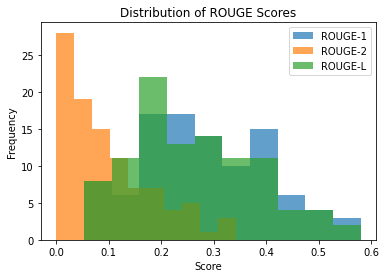

In [30]:
import matplotlib.pyplot as plt

plt.hist(rouge1_scores, bins=10, alpha=0.7, label='ROUGE-1')
plt.hist(rouge2_scores, bins=10, alpha=0.7, label='ROUGE-2')
plt.hist(rougeL_scores, bins=10, alpha=0.7, label='ROUGE-L')
plt.legend(loc='upper right')
plt.title('Distribution of ROUGE Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()


In [31]:
!pip install transformers
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration


In [32]:
!pip install transformers
!pip install torch


In [33]:
!pip install sentencepiece


In [34]:
tokenizer = T5Tokenizer.from_pretrained('t5-small')
model = T5ForConditionalGeneration.from_pretrained('t5-small')
model = model.cuda() if torch.cuda.is_available() else model


C:\Users\athir\anaconda3\lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\athir\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. If you see this, DO NOT PANIC! This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [42]:
def encode_data(article, summary):
    encoded_text = tokenizer.encode_plus(
        f"summarize: {article}",
        max_length=512,
        pad_to_max_length=True,
        return_tensors="pt",
        truncation=True
    )
    encoded_summary = tokenizer.encode(
        summary,
        max_length=150,
        pad_to_max_length=True,
        return_tensors="pt",
        truncation=True
    )
    return encoded_text["input_ids"], encoded_text["attention_mask"], encoded_summary

# Assuming articles and rule_based_summaries are your datasets
input_ids, masks, labels = [], [], []
for article, summary in zip(articles, rule_based_summaries):
    i, m, l = encode_data(article, summary)
    input_ids.append(i)
    masks.append(m)
    labels.append(l)

input_ids = torch.cat(input_ids, dim=0)
masks = torch.cat(masks, dim=0)
labels = torch.cat(labels, dim=0)


NameError: name 'rule_based_summaries' is not defined